# Best performing LSTM Model.

In [1]:
import pandas as pd

# Load the dataset
dataset_path = "C:/Users/ATAISH NEHRA/Downloads/merged_natural_disaster_dataset_1992_2020.csv"
data = pd.read_csv(dataset_path)

In [2]:
# Display the first few rows of the dataset to verify it's loaded correctly
print(data.head())

       Country  Year  Temperature  Drought  Extreme temperature  Flood  \
0  Afghanistan  1992       -0.294        0                    0      2   
1  Afghanistan  1993        0.220        0                    0      0   
2  Afghanistan  1994        0.430        0                    0      0   
3  Afghanistan  1995        0.359        0                    0      2   
4  Afghanistan  1996       -0.116        0                    0      1   

   Landslide  Storm  Total Disasters  Wildfire  ...  \
0          0      0                2         0  ...   
1          2      1                3         0  ...   
2          0      0                0         0  ...   
3          1      0                3         0  ...   
4          0      0                1         0  ...   

   Sparsely natural vegetated areas: Climate neutral  \
0                                          4275.2553   
1                                          4275.2243   
2                                          4275.2243   


In [4]:
# Select relevant features
features = [
    'Country', 'Year', 'Temperature', 'Sea level Value', 
    'Artificial surfaces (including urban and associated areas): Climate altering', 
    'Grassland: Climate regulating', 'Woody crops: Climate regulating', 
    'Terrestrial barren land: Climate neutral', 'Shrub-covered areas: Climate regulating', 
    'Carbon stocks in forests', 'Forest area', 'Index of carbon stocks in forests', 
    'Index of forest extent', 'Land area'
]
target = ['Total Disasters']

# Filter the dataset for selected features and the target
data_selected = data[features + target]

print(data_selected.head())

       Country  Year  Temperature  Sea level Value  \
0  Afghanistan  1992       -0.294        -5.160000   
1  Afghanistan  1993        0.220        -0.245294   
2  Afghanistan  1994        0.430        -2.592353   
3  Afghanistan  1995        0.359         2.565000   
4  Afghanistan  1996       -0.116        -5.005455   

   Artificial surfaces (including urban and associated areas): Climate altering  \
0                                            25.3207                              
1                                            25.7741                              
2                                            26.1577                              
3                                            26.6867                              
4                                            27.2273                              

   Grassland: Climate regulating  Woody crops: Climate regulating  \
0                     24035.3850                          87.4339   
1                     24035.4149      

In [6]:
import numpy as np
def create_sequences(data, n_years=7, target_col='Total Disasters'):
    sequences = []
    target = []
    for country in data['Country'].unique():
        country_data = data[data['Country'] == country].sort_values('Year')
        for i in range(len(country_data) - n_years):
            seq = country_data.iloc[i:i+n_years][[col for col in data.columns if col not in ['Country', 'Year', target_col]]].values
            sequences.append(seq)
            target.append(country_data.iloc[i + n_years][target_col])
    return np.array(sequences), np.array(target)

n_years = 7  # Using data from the past 7 years to create each sequence
X, y = create_sequences(data_selected, n_years=n_years)

print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

Shape of X: (682, 7, 12)
Shape of y: (682,)


In [7]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (545, 7, 12)
Shape of y_train: (545,)
Shape of X_test: (137, 7, 12)
Shape of y_test: (137,)


In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Define the LSTM model
model = Sequential([
    LSTM(300, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(150, activation='tanh', return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# Summary of the model
model.summary()

# Train the model
history = model.fit(X_train, y_train, epochs=150, validation_split=0.2, batch_size=32, verbose=2)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 7, 300)            375600    
                                                                 
 dropout_6 (Dropout)         (None, 7, 300)            0         
                                                                 
 lstm_7 (LSTM)               (None, 150)               270600    
                                                                 
 dropout_7 (Dropout)         (None, 150)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 151       
                                                                 
Total params: 646,351
Trainable params: 646,351
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
14/14 - 11s - loss: 43.8588 - val_lo

In [12]:
# Evaluate the model on the test set
test_loss = model.evaluate(X_test, y_test, verbose=2)

print(f"Test loss: {test_loss}")

5/5 - 0s - loss: 7.7807 - 121ms/epoch - 24ms/step
Test loss: 7.780685901641846


In [17]:
# Assuming the need to use the last 7 years of data for Nepal as input
nepal_data_latest = data_selected[data_selected['Country'] == 'Nepal'].sort_values(by='Year', ascending=False).head(7)

# Ensure it's in the correct chronological order
nepal_data_latest = nepal_data_latest.iloc[::-1]

# As there's no explicit scaling done previously, prepare the sequence directly
# Exclude 'Country', 'Year', and 'Total Disasters' for the input sequence
nepal_sequence = nepal_data_latest.drop(columns=['Country', 'Year', 'Total Disasters']).to_numpy()

# Reshape to match the input shape for LSTM ([samples, timesteps, features])
nepal_sequence_reshaped = nepal_sequence.reshape((1, 7, -1))

In [18]:
def iterative_predictions(model, initial_sequence, n_predictions):
    current_sequence = initial_sequence.copy()
    predictions = []

    for _ in range(n_predictions):
        # Predict the next year using the current sequence
        next_year_pred = model.predict(current_sequence)
        
        # Append the prediction to the list
        predictions.append(next_year_pred.flatten()[0])
        
        # Update the sequence with the prediction (shift left and append the prediction)
        current_sequence = np.roll(current_sequence, -1, axis=1)
        # Assuming the last feature correlates with 'Total Disasters' or similar target
        current_sequence[0, -1, -1] = next_year_pred
        
    return predictions

# Example: Predicting the next 5 years for Nepal
n_predictions = 5  # e.g., from 2021 to 2025
future_predictions = iterative_predictions(model, nepal_sequence_reshaped, n_predictions)

print("Future predictions:", future_predictions)

Future predictions: [2.5534906, 2.1812434, 2.0004954, 1.8602536, 1.7244987]


In [19]:
# Assuming X_test is already shaped as [samples, timesteps, features]
y_pred = model.predict(X_test)

In [33]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Flatten y_pred and y_test if they are not already flat
y_pred_flat = y_pred.flatten()
y_test_flat = y_test.flatten()

mae = mean_absolute_error(y_test_flat, y_pred_flat)
mse = mean_squared_error(y_test_flat, y_pred_flat)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Absolute Error (MAE): 2.1338927693610645
Mean Squared Error (MSE): 7.780685558099182
Root Mean Squared Error (RMSE): 2.7893880257323795


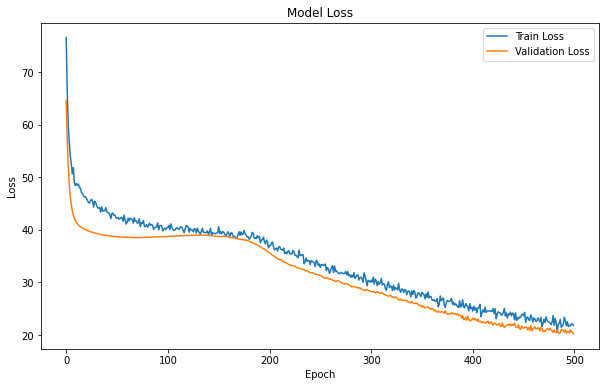

In [34]:
import matplotlib.pyplot as plt

# 1. Training and Validation Loss Curve
def plot_loss(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

plot_loss(history)

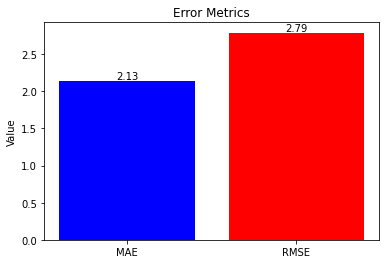

In [35]:
# 2. MAE and RMSE Visualization
def plot_mae_rmse(mae, rmse):
    metrics = ['MAE', 'RMSE']
    values = [mae, rmse]

    plt.figure(figsize=(6, 4))
    bars = plt.bar(metrics, values, color=['blue', 'red'])
    plt.title('Error Metrics')
    plt.ylabel('Value')

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval,2), ha='center', va='bottom')

    plt.show()

plot_mae_rmse(mae, rmse)

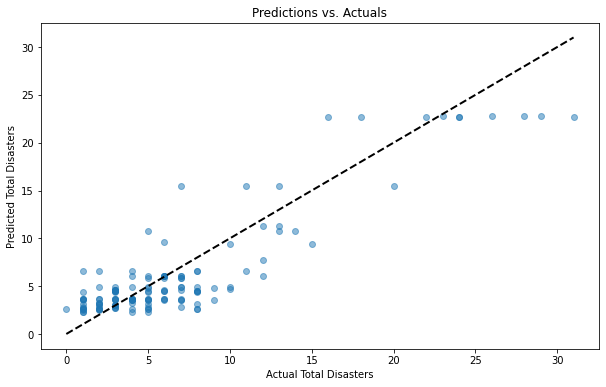

In [36]:
# 3. Predictions vs. Actuals Scatter Plot
def plot_predictions_vs_actuals(y_test, y_pred):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.title('Predictions vs. Actuals')
    plt.xlabel('Actual Total Disasters')
    plt.ylabel('Predicted Total Disasters')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    plt.show()

plot_predictions_vs_actuals(y_test_flat, y_pred_flat)

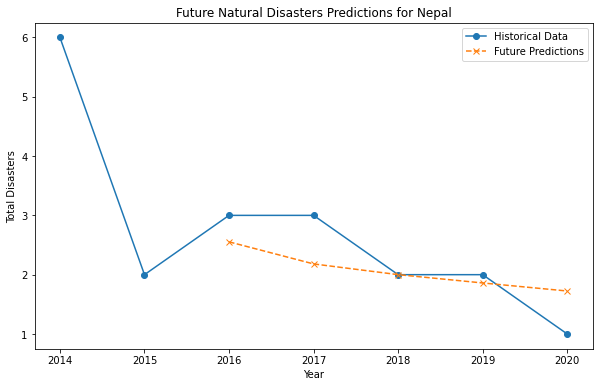

In [41]:
# 4. Future Predictions Trend
def plot_future_predictions(nepal_data_latest, future_predictions):
    years = nepal_data_latest['Year'].values[::1]  # Assuming years are in descending order
    future_years = [years[1] + i for i in range(1, n_predictions + 1)]

    plt.figure(figsize=(10, 6))
    plt.plot(years, nepal_data_latest['Total Disasters'].values, label='Historical Data', marker='o')
    plt.plot(future_years, future_predictions, label='Future Predictions', marker='x', linestyle='--')
    plt.title('Future Natural Disasters Predictions for Nepal')
    plt.xlabel('Year')
    plt.ylabel('Total Disasters')
    plt.legend()
    plt.show()

# Assuming you have future_predictions as a list of predicted values for the next years
plot_future_predictions(nepal_data_latest, future_predictions)

In [27]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization
from tensorflow.keras.optimizers import Adam

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Attention and Normalization
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = Dropout(dropout)(x)
    x = LayerNormalization(epsilon=1e-6)(x + inputs)

    # Feed Forward Network
    ff = Dense(ff_dim, activation="relu")(x)
    ff = Dropout(dropout)(ff)
    ff = Dense(inputs.shape[-1])(ff)
    ff = Dropout(dropout)(ff)
    output = LayerNormalization(epsilon=1e-6)(x + ff)
    return output

# Define inputs
input_shape = X_train.shape[1:]  # Should be (timesteps, features)
inputs = Input(shape=input_shape)

# Transformer Encoder
x = transformer_encoder(inputs, head_size=256, num_heads=4, ff_dim=4, dropout=0.25)

# Output layer
outputs = Dense(1)(x[:, -1, :])  # We predict based on the last timestep

# Compile model
model = Model(inputs, outputs)
model.compile(optimizer=Adam(learning_rate=1e-4), loss="mse")

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 7, 12)]      0           []                               
                                                                                                  
 multi_head_attention_2 (MultiH  (None, 7, 12)       52236       ['input_3[0][0]',                
 eadAttention)                                                    'input_3[0][0]']                
                                                                                                  
 dropout_14 (Dropout)           (None, 7, 12)        0           ['multi_head_attention_2[0][0]'] 
                                                                                                  
 tf.__operators__.add_4 (TFOpLa  (None, 7, 12)       0           ['dropout_14[0][0]',       

In [28]:
history = model.fit(X_train, y_train, validation_split=0.2, epochs=500, batch_size=32, verbose=2)

Epoch 1/500
14/14 - 1s - loss: 76.6014 - val_loss: 64.6566 - 1s/epoch - 100ms/step
Epoch 2/500
14/14 - 0s - loss: 66.5406 - val_loss: 57.4478 - 118ms/epoch - 8ms/step
Epoch 3/500
14/14 - 0s - loss: 59.8498 - val_loss: 52.2444 - 110ms/epoch - 8ms/step
Epoch 4/500
14/14 - 0s - loss: 56.7511 - val_loss: 48.7860 - 116ms/epoch - 8ms/step
Epoch 5/500
14/14 - 0s - loss: 54.1929 - val_loss: 46.4017 - 112ms/epoch - 8ms/step
Epoch 6/500
14/14 - 0s - loss: 52.6477 - val_loss: 44.7814 - 113ms/epoch - 8ms/step
Epoch 7/500
14/14 - 0s - loss: 50.6607 - val_loss: 43.6408 - 118ms/epoch - 8ms/step
Epoch 8/500
14/14 - 0s - loss: 51.8359 - val_loss: 42.8507 - 119ms/epoch - 9ms/step
Epoch 9/500
14/14 - 0s - loss: 49.0503 - val_loss: 42.2430 - 116ms/epoch - 8ms/step
Epoch 10/500
14/14 - 0s - loss: 48.3864 - val_loss: 41.7795 - 117ms/epoch - 8ms/step
Epoch 11/500
14/14 - 0s - loss: 48.8098 - val_loss: 41.4255 - 124ms/epoch - 9ms/step
Epoch 12/500
14/14 - 0s - loss: 48.5051 - val_loss: 41.1608 - 111ms/epoch -

In [29]:
# Evaluate the model on the test set
test_loss = model.evaluate(X_test, y_test, verbose=2)
print(f"Test loss: {test_loss}")

5/5 - 0s - loss: 17.9188 - 42ms/epoch - 8ms/step
Test loss: 17.91875457763672


In [32]:
# Example: Predicting the next 5 years for 'Nepal'
# Assuming 'nepal_sequence_reshaped' is your prepared input sequence for Nepal
n_predictions = 5  # Number of years to predict into the future

predictions = model.predict(nepal_sequence_reshaped)
print("Predictions for the next 5 years:", predictions.flatten()[:n_predictions])

Predictions for the next 5 years: [3.7723074]
